# Fake News Detection
----

## Abstract
---
News is published daily but how do we distinguish it from being real or fake news? The purpose of this study is to identify factors that can be used to classify an article to be real or fake.

Factors that can be inspected by viewers before they start reading.

As articles are relatively large, a machine learning model will be trained to classify articles as real or fake based on previous observations. This can be useful in identifying articles that are fake and remove them before readers become misled.

<img src = "https://www.internetmatters.org/wp-content/uploads/2020/10/protect-your-child-fake-news.png" alt = "Fake News Detection" width = 1000 height = 800></img>

## Introduction
---
Fake news is false or misleading information presented as news. It often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue. However, the term does not have a fixed definition, and has been applied more broadly to include any type of false information, including unintentional and unconscious mechanisms, and also by high-profile individuals to apply to any news unfavourable to his/her personal perspectives.

### Import required packages
---

In [31]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import re
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True) 
template = 'plotly_dark'

In [2]:
df = pd.read_csv('data/fake_news.csv')

**The dataset imported contains the following features:**

* **id:** index factor
* **title:** News article headline/title
* **author:** author of the news article
* **text:** the body of the article
* **label:** marks the article as one of two outcomes:
    * 0: Real
    * 1: Fake

In [3]:
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


There are null values that needs to be dropped. We need to only drop observations containing null values in the `text` column to reserve as much observations as possible.

The `title` and `author` columns' null values will be replace with empty strings.

In [5]:
df.dropna(subset = ['text'], axis = 0, inplace = True)
df.fillna('', inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20761 non-null  object
 2   author  20761 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB


Change the binary format into text for better readibility

In [7]:
df['label'] = df['label'].apply(lambda x: 'Real' if x == 0 else 'Fake')

Now that there are no null values in our data, we can proceed with preprocessing.

### Preprocessing
---

Before preprocessing the data, we have to make all text lowercase to avoid case-sensitive complications.

In [10]:
df['text'] = df['text'].apply(lambda x: x.lower())

#### Remove all stopwords
---
The most common method of removing stopwords is using a `loop` / `list comprehension`. The common method used is the following:

<code>' '.join([x for x in text.split() if x not in stopwords])</code>

This is good for short paragraphs but in cases where paragraphs contain hundreds to thousands of words, it will cause a major increase in compute time.

Alternatively, using regular expressions can lower compute time and regex works well with large amounts of text.

In [12]:
stop_words = stopwords.words('english') 

In [13]:
def remove_stopwords(news):
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    return pattern.sub('', news)

In [20]:
df['preprocessed_text'] = df['text'].apply(remove_stopwords)

#### Tokenization and Punctuation Removal
---
For this step, `RegexpTokenizer` will be used. As the name states, it tokenizes text plus it has an additional feature that uses regular expressions to remove punctuations.

In [21]:
tokenizer = RegexpTokenizer(r"\w+")

In [22]:
df['preprocessed_text'] = df['preprocessed_text'].apply(
    lambda x: ' '.join(tokenizer.tokenize(x))
)

In [25]:
df.head()

,id,title,author,text,label,preprocessed_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,house dem aide: we didn’t even see comey’s let...,Fake,house dem aide even see comey letter jason cha...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,ever get the feeling your life circles the rou...,Real,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"why the truth might get you fired october 29, ...",Fake,truth might get fired october 29 2016 tension ...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,videos 15 civilians killed in single us airstr...,Fake,videos 15 civilians killed single us airstrike...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,print \nan iranian woman has been sentenced to...,Fake,print iranian woman sentenced six years prison...


You must be wondering why there was no Lemmatization or Stemming done. The reason for that is to reverse the integrity of words used in the articles. Lemmatization and Stemming is good to use for transforming words into their standard form but doing so the text can lose it's original meaning and including the fact that Stemming occasionally returns words that are not in the vocabulary.

Now that preprocessing has concluded, we can move on to Exploratory Data Analysis.

### Exploratory Data Analysis
---
Firstly, observing the top 10 most publishing authors for real and fake news. Then, we will take a look at the most frequently used words for real and fake news

In [27]:
def author_count(label):
    author = df[(df['label'] == label) & (df['author'] != '')].groupby('author')['label'].count()
    return pd.DataFrame({
        'Authors': author.index,
        'Articles': author.values
    }).sort_values(by = 'Articles')

real_author = author_count('Real')

In [32]:
fig = px.bar(
    real_author[-10:], 
    y = 'Authors', 
    x = 'Articles', 
    orientation = 'h', 
    title = 'Top 10 Authors of Factual Articles',
    color_discrete_sequence = ['green']
)

fig.update_layout(
    template = template
)

fig.show()

All authors above are writers for Breitbart News. Breitbart News Network, known commonly as Breitbart News, Breitbart, or Breitbart.com, is an American far-right syndicated news, opinion, and commentary website.

In [29]:
fake_author = author_count('Fake')

In [33]:
fig = px.bar(
    fake_author[-10:], 
    y = 'Authors', 
    x = 'Articles', 
    orientation = 'h', 
    title = 'Top 10 Authors of Fake News',
    color_discrete_sequence = ['red']
)

fig.update_layout(
    template = template
)

fig.show()

The authors publishing fake news use fake names to hide their identity. This can be a factor in classifying articles to be fake news. When observing an article during our daily lives, it is best to check the company publishing the article. If there is no company, check the author's name and do a search to see if he/she is a legit author of a news company.

In [44]:
real = ' '.join(df[df['label'] == 'Real']['preprocessed_text'])
fake = ' '.join(df[df['label'] == 'Fake']['preprocessed_text'])

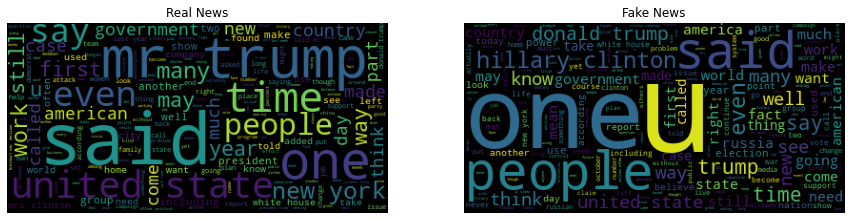

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (15, 12))

wordcloud_real = WordCloud(
    background_color = 'black'
).generate(real)

wordcloud_fake = WordCloud(
    background_color = 'black'
).generate(fake)

ax[0].imshow(wordcloud_real)
ax[0].axis('off')
ax[0].set_title('Real News')
ax[1].imshow(wordcloud_fake)
ax[1].set_title('Fake News')
ax[1].axis('off')
plt.show()

**Real News:** The word "said" appears more frequently, referring to quotes made in articles.

**Fake News:** Fake news contains many words stated in real news but the "u" letter occurs more frequently. "U" refers to "you", it is slang commonly used in texting. This implements that noticing slang in an article can classify it as being fake.

This concludes EDA. Time to move to the next step, which is model building.

## Model Building
---
The model that will be used is "Passive Aggressive Classifier"

#### What is the Passive Aggressive Classifier?
---
Passive Aggressive Classifier is a classification algorithm that falls under the category of online learning in machine learning.
##### What is online learning?
In online learning, a machine learning model is trained and deployed in production in a way that it continues to learn as new data sets arrive. So we can say that an algorithm like Passive Aggressive Classifier is best for systems that receive data in a continuous stream.

##### How does the Passive Agressive algorithm work?
This can be explained by referring to the algorithm's name:
* **Passive:** If the prediction is correct, keep the model and do not make any changes. i.e., the data in the example is not enough to cause any changes in the model. 
* **Aggressive:** If the prediction is incorrect, make changes to the model. i.e., some change to the model may correct it.

**Note:** The algorithm does not require a learning rate.

##### Important parameters:
* **C:** This is the regularization parameter, and denotes the penalization the model will make on an incorrect prediction
* **max_iter:** The maximum number of iterations the model makes over the training data.
* **tol:** The stopping criterion. If it is set to None, the model will stop when (loss > previous_loss – tol). By default, it is set to 1e-3.

#### Additional Algorithms used:
----
* Pipeline
* TfidfVectorizer

##### Pipeline
As the name suggests, pipeline class allows sticking multiple processes into a single estimator.

##### TfidfVectorizer
The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents.

The model will be trained on preprocessed text data and text data that was not preprocessed to see on which data does the model perform best.

In [88]:
df['label'].value_counts()

Real    10387
Fake    10374
Name: label, dtype: int64

Checking if the classes in the `label` column is evenly distributed can help explain if the model is favouring the majority class. 

But, the classes are approximately equally distributed therefore sampling is not required.

#### Preprocessing Data
---

In [73]:
X = df['preprocessed_text']
y = df['label']

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [75]:
pa = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = 'english', max_df = 0.85, ngram_range = (2, 2))),
    ('pac', PassiveAggressiveClassifier())
])

In [76]:
pa.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, ngram_range=(2, 2),
                                 stop_words='english')),
                ('pac', PassiveAggressiveClassifier())])

In [77]:
ypred = pa.predict(X_test)

In [91]:
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

        Fake       0.97      0.95      0.96      2074
        Real       0.95      0.97      0.96      2079

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153



#### Data with no preprocessing
---

In [78]:
X_ = df['text'] # Only X because we have already y 

In [79]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, y, test_size = 0.2, random_state = 42)

In [80]:
pa_ = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = 'english', max_df = 0.85, ngram_range = (2, 2))),
    ('pac', PassiveAggressiveClassifier())
])

In [81]:
pa_.fit(X_train_, y_train_)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, ngram_range=(2, 2),
                                 stop_words='english')),
                ('pac', PassiveAggressiveClassifier())])

In [84]:
ypred_ = pa_.predict(X_test_)

In [92]:
print(classification_report(y_test_, ypred_))

              precision    recall  f1-score   support

        Fake       0.98      0.95      0.96      2074
        Real       0.95      0.98      0.96      2079

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153



#### Comparison 
---

In [86]:
pd.DataFrame({
    'Preprocessing': f1_score(y_test, ypred, average = 'weighted'),
    'No Preprocessing': f1_score(y_test_, ypred_, average = 'weighted')
}, index = ['F1 Score'])

,Preprocessing,No Preprocessing
F1 Score,0.963636,0.964117


The model performed better on data that was not preprocessed with a `0.00048` performance difference.

## Conclusion
---
Fake news can mislead people in many ways. By analysing the differences between real news and fake news can point out factors that viewers can look out for, for example, slang, suspicious author names, or if the article sounds like it is stemming from personal point of view.

The model used, performed best on data that was not preprocessed, therefore this can speed up the classifying process by avoiding preprocessing procedures and only inserting the text data into the model.